In [28]:
from pyjarowinkler import distance
from math import*
import nltk
from sklearn.cluster import KMeans
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from stop_words import get_stop_words
from nltk.stem.porter import PorterStemmer
from gensim import corpora, models
from sklearn.metrics import euclidean_distances
import gensim
import pymysql
import pymysql.cursors
from gensim import corpora, models
import math
from textblob import TextBlob as tb
from sklearn import metrics
from sklearn.metrics import pairwise_distances
import numpy as np
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import requests
import json
import time
from scipy.spatial.distance import cdist

In [29]:
def macro_precision(result, y, n_cluster):
    groupDict = {}
    i= 0
    for item in result:
        if item in groupDict:
            groupDict[item].append(i)
        else:
            groupDict[item] = [i]
        i = i + 1

    trueDict = {}
    i = 0
    for item in y:
        if item not in trueDict:
            trueDict[item] = [i]
        else:
            trueDict[item].append(i)
        i = i + 1

    inverseTrue = {}
    for key in trueDict.keys():
        for item in trueDict[key]:
            inverseTrue[item] = key
    
    totalNotSame = 0
    for key in groupDict.keys():
        temp = groupDict[key]
        f_id = -1
        i = 0
        control = True
        while i < len(temp) and control == True:
            f_id_cur = inverseTrue[temp[i]]
            if f_id == -1:
                f_id = f_id_cur
            else:
                if f_id_cur != f_id:
                    totalNotSame += 1
                    control = False
            i += 1
                    
    return (n_cluster-totalNotSame) / n_cluster

def macro_recall(result, y, n_cluster):
    return macro_precision(y, result, n_cluster)
    

def micro_precision(result, y):
    lenC = len(result)
    groupDict = {}
    i= 0
    for item in result:
        if item in groupDict:
            groupDict[item].append(i)
        else:
            groupDict[item] = [i]
        i = i + 1

    trueDict = {}
    i = 0
    for item in y:
        if item not in trueDict:
            trueDict[item] = [i]
        else:
            trueDict[item].append(i)
        i = i + 1

    inverseTrue = {}
    for key in trueDict.keys():
        for item in trueDict[key]:
            inverseTrue[item] = key
    
    totalSame = 0
    for key in groupDict.keys():
        temp = groupDict[key]
        output = {}
        maxO = 0
        maxKey = ""
        for item in temp:
            f_id = inverseTrue[item]
            if f_id not in output:
                output[f_id] = 1
            else:
                output[f_id] += 1
            
            if output[f_id] > maxO:
                maxO = output[f_id]
                maxKey = key
                
        totalSame += maxO
    return  totalSame / lenC
                
def micro_recall(result, y):
    return micro_precision(y, result)


def pairwise_precision(result, y):
    lenC = len(result)
    groupDict = {}
    i= 0
    for item in y:
        if item in groupDict:
            groupDict[item].append(i)
        else:
            groupDict[item] = [i]
        i = i + 1

    trueDict = {}
    i = 0
    for item in result:
        if item not in trueDict:
            trueDict[item] = [i]
        else:
            trueDict[item].append(i)
        i = i + 1

    inverseTrue = {}
    for key in trueDict.keys():
        for item in trueDict[key]:
            inverseTrue[item] = key
    
    totalPair = 0
    totalHit = 0
    for key in groupDict.keys():
        temp = groupDict[key]
        i = 0
        j = 0
        while i < len(temp):
            while j < len(temp):
                f_id_i = inverseTrue[temp[i]]
                f_id_j = inverseTrue[temp[j]]
                if f_id_i == f_id_j:
                    totalHit += 1
                j += 1
                totalPair += 1
            i += 1
        
    return  totalHit / totalPair


def pairwise_recall(result, y):
    lenC = len(result)
    groupDict = {}
    i= 0
    for item in y:
        if item in groupDict:
            groupDict[item].append(i)
        else:
            groupDict[item] = [i]
        i = i + 1

    trueDict = {}
    i = 0
    for item in result:
        if item not in trueDict:
            trueDict[item] = [i]
        else:
            trueDict[item].append(i)
        i = i + 1

    inverseGroup = {}
    for key in groupDict.keys():
        for item in groupDict[key]:
            inverseGroup[item] = key
    
    totalPair = 0
    totalHit = 0
    for key in trueDict.keys():
        temp = trueDict[key]
        i = 0
        j = 0
        while i < len(temp):
            while j < len(temp):
                f_id_i = inverseGroup[temp[i]]
                f_id_j = inverseGroup[temp[j]]
                if f_id_i == f_id_j:
                    totalHit += 1
                j += 1
                totalPair += 1
            i += 1
        
    return  totalHit / totalPair

In [30]:
def connect_to_database():
    options = {
        'user': "root",
        'passwd': "root",
        'db': "KnowBase",
        'cursorclass' : pymysql.cursors.DictCursor
    }
    db = pymysql.connect(**options)
    db.autocommit(True)
    return db


db = connect_to_database()
cur = db.cursor()
string = "select b.freebase_id, b.entity, b.relation, b.value, b.link_am_score, b.link_scroe, b.base_id, "
string += "b.freebase_entity from NoiseEntity b"
cur.execute(string)
results = cur.fetchall()
groundTrue = {}
label = []
entity = []
entityDict = {}
y = []
i= 0
wordList = []
allWord = {}
idx = 0
file_t = open("data.txt", 'w')
for result in results:
    if result["freebase_id"] not in groundTrue:
        groundTrue[result["freebase_id"]] = i
        label.append(result["freebase_entity"].lower())
        i = i + 1
    if result["entity"] not in entityDict:
        entityDict[result["entity"].lower()] = 1
    entity.append(result["entity"].lower())
    y.append(groundTrue[result["freebase_id"]])
    
    temp = {}
    temp["n"] = result["entity"].lower().split()
    list_A = result["relation"].lower().split()
    list_A.extend(result["value"].lower().split())
    temp["A"] = list_A
    temp["f_id"] = result["freebase_id"]
    temp["f_entity"] = result["freebase_entity"]
    temp["score"] = result["link_scroe"]
    temp["am_score"] = result["link_am_score"]
    temp["relation"] = result["relation"]
    temp["value"] = result["value"]
    temp["id"] = result["base_id"]
    wordList.append(temp)
    
    entity_t = result["entity"].split()
    for word in entity_t:
        if word.lower() not in allWord:
            allWord[word.lower()] = idx
            idx += 1

In [31]:
list_in = []
keys = list(allWord.keys())
for item in entity:
    temp = [0]*len(keys)
    item = item.split()
    for word in item:
        temp[allWord[word]] = 1
    list_in.append(temp)

In [32]:
kmeans = KMeans(n_clusters=150, random_state=0).fit(list_in)
result = list(kmeans.labels_)
print(macro_precision(result, y, 150))
print(macro_recall(result, y, 150))
print(micro_precision(result, y))
print(micro_recall(result, y))
print(pairwise_precision(result, y))
print(pairwise_recall(result, y))

0.98
0.8733333333333333
0.9852558542931483
0.946516334200636
0.9035848511130384
0.9848222029488292


130
135
140
145
150
155
160
165
170


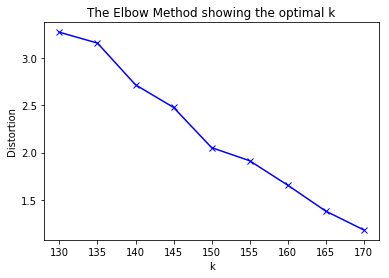

In [33]:
distortions = []
K = [130, 135, 140, 145, 150, 155, 160, 165, 170]
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(list_in)
    kmeanModel.fit(list_in)
    print(k)
    distortions.append(sum(np.min(cdist(list_in, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / len(list_in[0]))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()